# Optimization for machine/deep learning: homework 2

### General instructions

Complete the exercises listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

Included with the notebook are 

- a custom contour plotting function called `custom_plotter.py` that plots contour functions (for visualization purposes) and cost function histories


- datasets: `2d_linregress_data.csv` used for linear regression


be sure you have these files located in the same directory where you put this notebook!

In [1]:
### inport statements
# the next three lines allow you to easily make plots in notebook, and use a nice renderer (for prettier pictures)
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# the custom plotter we will be using for contour plots
import custom_plotter

# import some standard libraries
import numpy as np
import matplotlib.pyplot as plt
import copy   

# include these two statements so that you can work on backend .py files if you like without having to restart the notebook kernel every time you make a change to a .py file
%load_ext autoreload
%autoreload 2

#### <span style="color:#a50e3e;">Exercise 1. </span>   Perform alternating descent on simple quadratic function

In this exercise you will code up a coordinate descent algorithm [discussed in class](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_13_unconstrained_optimality_conditions.html) for minimizing a generic convex [quadratic function](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_10_quadratic_functions.html).  These take the form 

\begin{equation}
g\left(\mathbf{w}\right)=a + \mathbf{b}^{T}\mathbf{w} + \mathbf{w}^{T}\mathbf{C}\mathbf{w}
\end{equation}

where $\mathbf{C}$ is a symmetric $N\times N$ matrix with all nonnegative eigenvalues, $\mathbf{b}$ is an $N\times 1$ vector, and $a$ is a constant.  No need to worry in general about the matrix $\mathbf{C}$ if you are unfamilliar with the concept of eigenvalues - in this assignment (and in virtually every application in AI) you always work with matrices $\mathbf{C}$ that satisfy this requirement.

In the Python cell below we plot the $N = 2$ input quadratic given constants

\begin{array}
\
a = 0 \\
\mathbf{b} = \begin{bmatrix}10 \\ 10 \end{bmatrix} \\
\mathbf{C} = \begin{bmatrix} \,\,\,\,\,5 \,\,\, -3 \\ -3 \,\,\,\,\,\,\,\, 5 \end{bmatrix}
\end{array}

using the associated ``custom_plotter.py``.  In the left panel is shown the surface plot of this function, while on the right we show its contour plot (here the contours are colored dark to light as the function gets smaller).  The minimum of the function lies inside the smallest width elliptical contour.

<IPython.core.display.Javascript object>


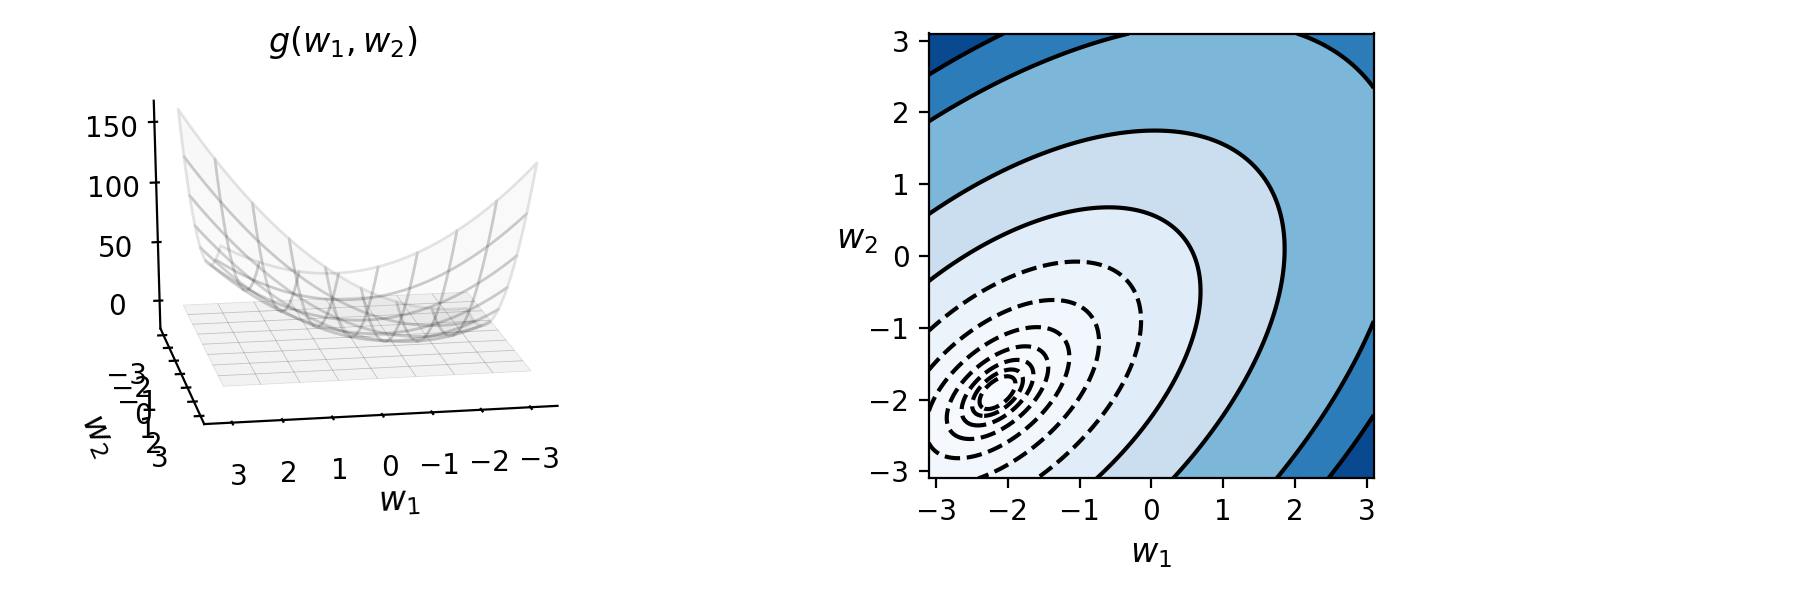

In [2]:
# define constants for a N=2 input quadratic
a = 0
b = 10*np.ones((2,1))
C = np.array([[5,-3],[-3,6]])

# a quadratic function defined using the constants above
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# create an instance of the visualizer and plot the function above
demo = custom_plotter.Visualizer();
demo.draw_setup(g,num_contours = 30,view = [20,80])

In the example 7 from the [class notes on unconstrained optimality conditions](https://jermwatt.github.io/mlrefined/blog_posts/Computational_Calculus/Part_13_unconstrained_optimality_conditions.html) we see that the first order system of equations for finding the minimium of a convex quadratic is given by

\begin{equation}
\nabla g(\mathbf{w}) = 2\mathbf{C}\mathbf{w} + \mathbf{b} = \mathbf{0}_{N\times 1}
\end{equation}

This is a system of $N$ equations whose $n^{th}$ equation can be written generally as 

\begin{equation}
\frac{\partial}{\partial w_{n}}g(\mathbf{w})=2\left(c_{n1}w_1 + c_{n2}w_2 + c_{n3}w_3 +  \cdots + c_{nN}w_N\right) + b_n = 0
\end{equation}

With alternating descent we will solve each of these equations *sequentially* - starting with $w_1$ (keeping all other weights fixed), then $w_1$ (keeping all other weights fixed, with our updated value for $w_0$), etc., to the final weight $w_N$ (with all weights fixed, with $w_0$, $w_1$,...,$w_{N-1}$ fixed at their updated values).  We can then start again at $w_1$ and sweep through the weights again to make a second update, cycling through the weights several times before halting the procedure.

Solving the above for $w_n$ alone, keeping all other weights fixed.  Solving the above for $w_n$ gives a closed form algebraic solution

\begin{equation}
w_n = -\frac{c_{n,1}^{\,}w_1^{\,} + c_{n,2}^{\,}w_2^{\,} + \cdots + c_{n,n-1}^{\,}w_{n-1}^{\,} + c_{n,n+1}^{\,}w_{n+1}^{\,} + \cdots c_{n,N}^{\,}w_{N}^{\,} + \frac{1}{2}b_n^{\,}}{c_{n,n}^{\,}}
\end{equation}

Its time to get to work implementing this scheme!  The Python cell below contains the wrapper ``alternating_descent_for_quadratic`` where you will code up alternating descent using the update step above to minimize a general convex quadratic.  The function takes in constants defining the quadratic $a$, $\mathbf{b}$, and $\mathbf{C}$ and - since the point here is to gain the intuition for how altnerating descent works - outputs the weights at each and every step of the process.  

Afterwards you can run this weight history through seveal functions in ``custom_plotter`` to e.g., graph the cost function decrease at each step of the method,  or visualize the path directly on the contour plot of the function (see the cells after this wrapper to see how you can do this).

A good portion of this wrapper is filled out for you - including settings (like maximum number of iterations to take), as well the general outline of the method.  This includes:

- an outer loop: each step involves a sweep through each and every weight

- in inner loop: where each individual weight update is made

Use the quadratic plotted previously to test out your code!  Note in terms of the function decrease at each step of the method: each step should - in general - decrease the value of the quadratic.  However note that you may not see decrease at *every* step.

In [3]:
def alternating_descent_for_quadratic(a,b,C):
    '''
    Alternating descent wrapper for general quadratic function. Here
    
    a - a constant
    b - an Nx1 vector
    C - an NxN matrix (symmetric and all nonnegative eigenvalues)
    '''
    
    # settings 
    its = 1000                         # max its to run
    tol = 10**(-8)                     # tolerance to between sweeps to stop (optional)
    N = len(b)                         # length of weights
    w = np.zeros((N,1))                # initialization
    w_history = [copy.deepcopy(w)]     # record each weight for plotting
    
    # outer loop - each is a sweep through every variable once
    i = 0
    g_change = np.inf; gval1 = g(w);    
    while i < its and g_change > tol:
        # inner loop - each is a single variable update
        ##### YOUR CODE GOES HERE #####
        for n in range(N):
            curr_sum = 0
            for inner_n in range(N):
                if inner_n != n:
                    curr_sum += C[n, inner_n] * w[inner_n]
            w[n] = -(curr_sum + (b[n]/2)) / C[n][n]
            w_history.append(copy.deepcopy(w))
        # update counter and tolerance measure
        gval2 = copy.deepcopy(gval1)
        gval1 = g(w)
        g_change = abs(gval1 - gval2)/float(np.size(w))
#         print (gval2, gval1, g_change)
        i+=1
    return w_history

To test out your implementation you can call the function by activating the next Python cell.

In [4]:
# define constants for a N=2 input quadratic
a = 0
b = 10*np.ones((2,1))
C = np.array([[5,-3],[-3,6]])

# run your alternating descent code
w_history = alternating_descent_for_quadratic(a,b,C)

To see how a run of your code went plot the cost function value (the value of the quadratic) based on your output weight history - by activating the cell below.

<IPython.core.display.Javascript object>


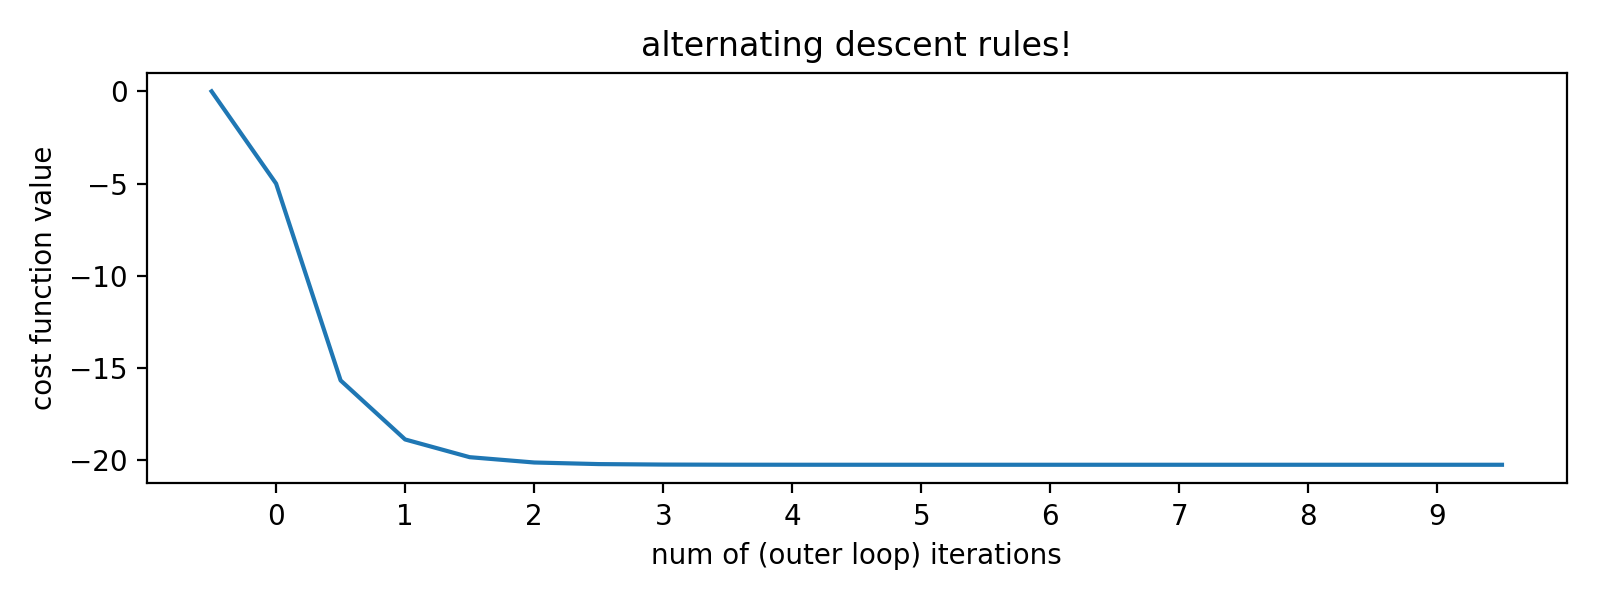

In [5]:
# define the quadratic
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# plot resulting cost function history based on w_history
demo = custom_plotter.Visualizer();
demo.plot_alternating_descent_cost_history(g,w_history)

You can also visualize the path your method takes by plotting the weights on top of the contour plot of the quadratic, as shown in the next cell.

<IPython.core.display.Javascript object>


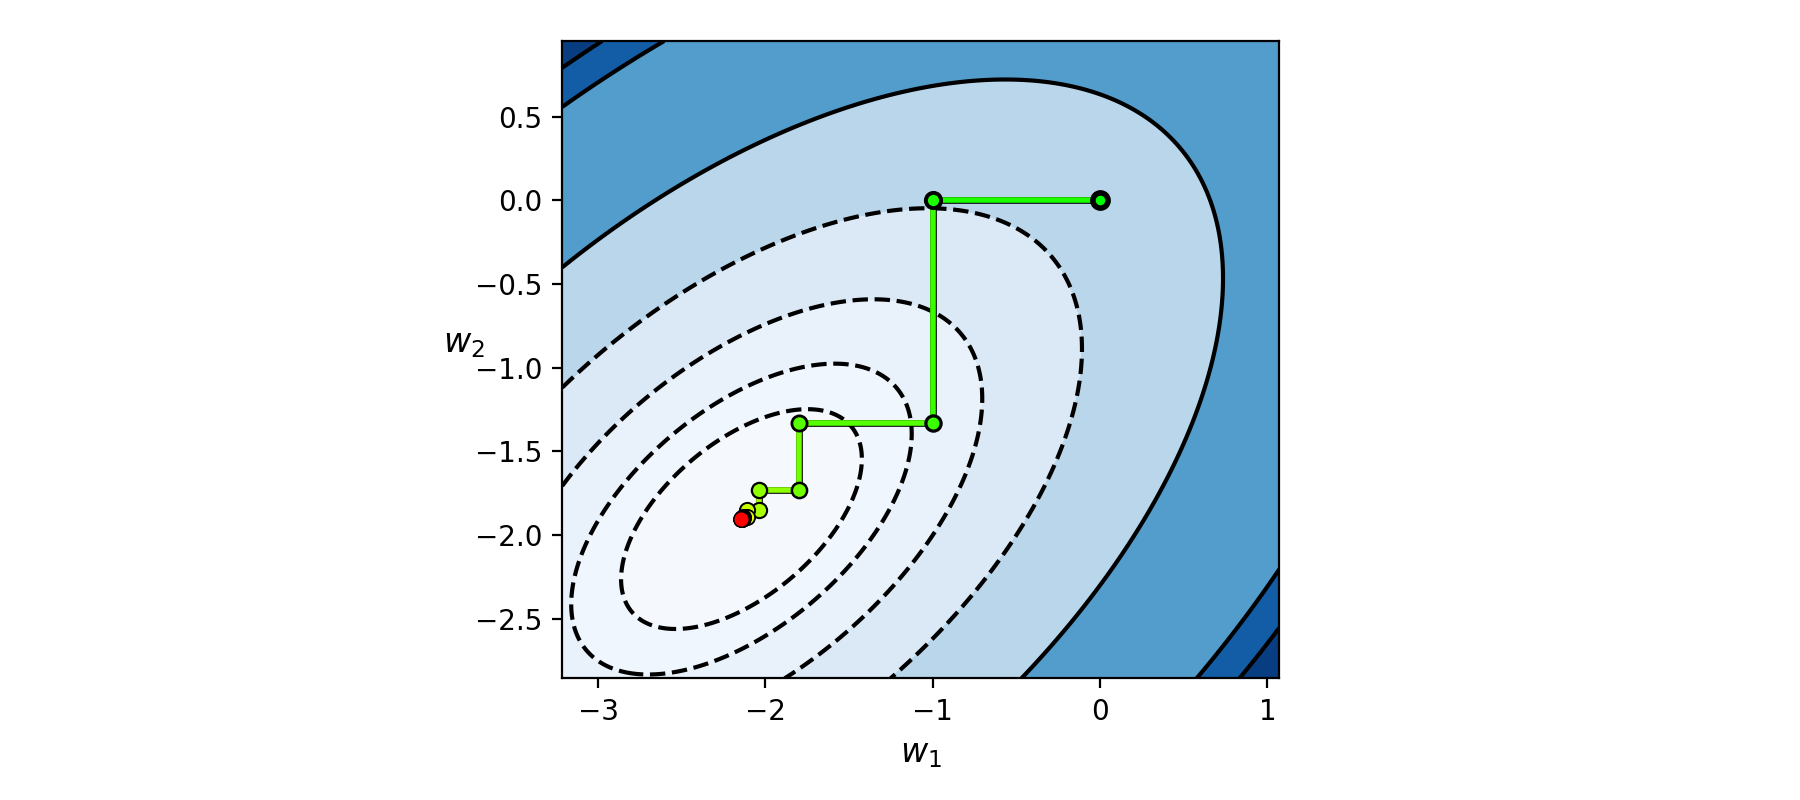

In [6]:
# plot the path taken by alternating descent by plotting each weight from your history
demo.show_path(g,w_history,num_contours = 20)

With your alternating descent method complete you can now quickly minimize any convex quadratic function!  Put it to the test: in the next Python cell we define a random convex quadratic in 10 dimensions.  Activate the cell to create these random constants.  Then - in the cell that follows - run your alternating descent code to minimie it, plotting the cost function history afterwards.  We can no longer visualize the path your algorithm takes - it lives in 10 dimensions!

In [7]:
# define a random quadratic 
dim = 10
C = np.random.randn(dim,dim)
C = np.dot(C,C.T)
C /= np.linalg.norm(C,'fro')
b = np.random.randn(dim,1)
b /= np.linalg.norm(b)
a = 0

# run your alternating descent code
w_history = alternating_descent_for_quadratic(a,b,C)

Now plot the cost function over your weight history.

<IPython.core.display.Javascript object>


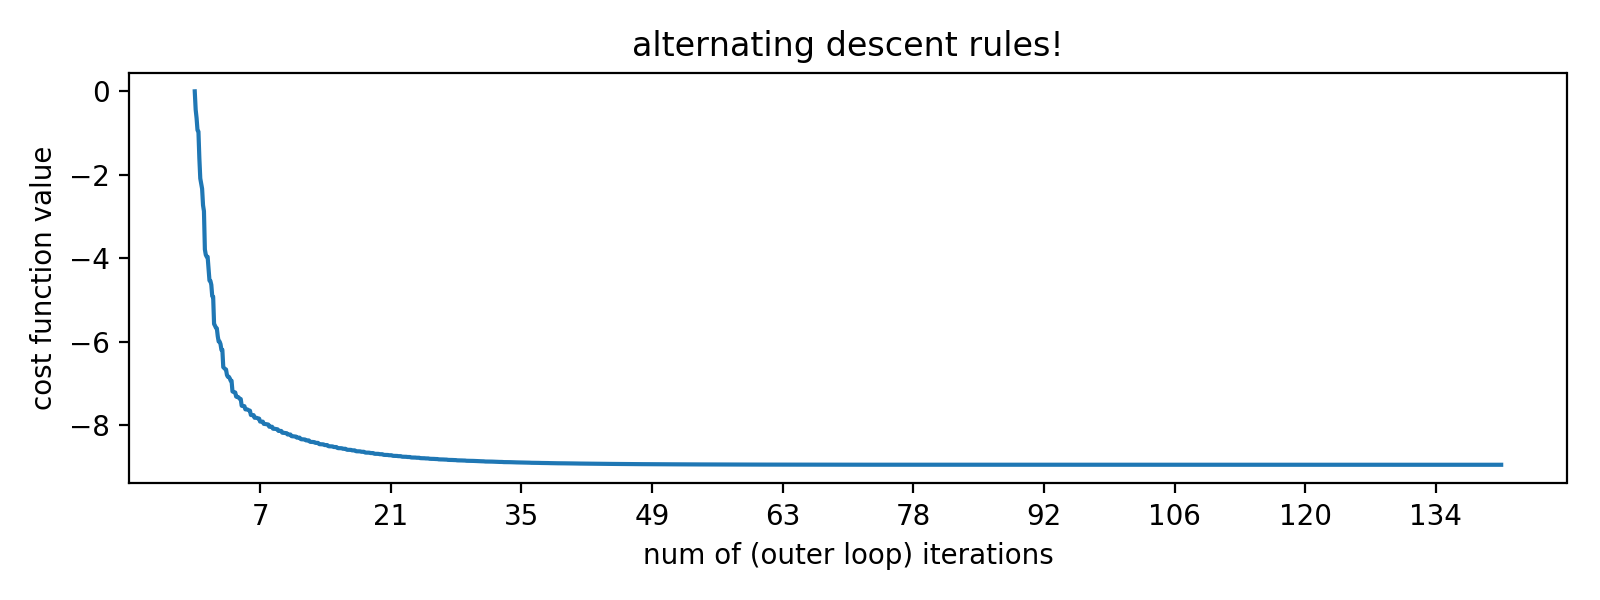

In [8]:
### plot cost function history based on output history of weights
# make sure you have defined the quadratic itself
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# plot resulting cost function history based on w_history
demo = custom_plotter.Visualizer();
demo.plot_alternating_descent_cost_history(g,w_history)

#### <span style="color:#a50e3e;">Exercise 2. </span>   Perform alternating descent to minimize Least Squares for linear regression

With our alternating descent code in hand we can now quickly solve linear regression problems.  This is because the cost function we have to minimize - the Least Squares problem for linear regression - is just a convex quadratic!  In the next cell we import a simple 2-d linear regression dataset.  Afterwards you will translate the Least Squares function for fitting a line to this data into a quadratic function, which you can then minimimize using the alternating descent code above.

<IPython.core.display.Javascript object>


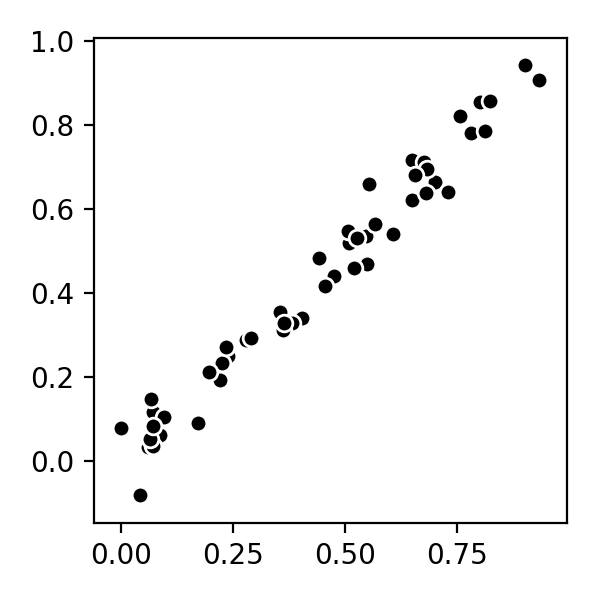

In [9]:
# a linear regression dataset
data = np.loadtxt('2d_linregress_data.csv',delimiter=',')
x = data[:,0]
y = data[:,1]


# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')

For a dataset of $P$ points with $N = 1$ inputs the Least Squares cost function for linear regression is given as 

\begin{equation}
g(w_0,w_1) = \sum_{p=1}^{P} \left(w_0 + w_1x_p - y_p \right)^2
\end{equation}

This is actually a convex quadratic function!  

First: verify that you can rewrite the Least Squares function above equivalently as a generic quadratic function

\begin{equation}
g(\mathbf{w}) = a + \mathbf{b}^T \mathbf{w} + \mathbf{w}^T \mathbf{C} \mathbf{w}
\end{equation}

where

\begin{array}
\
a = \sum_{p=1}^{P} y_p^2 \\
\mathbf{b} = -2\sum_{p=1}^{P} \mathbf{x}_p y_p \\
\mathbf{C} = \sum_{p=1}^{P}\mathbf{x}_p \mathbf{x}_p^T
\end{array}

and $\mathbf{x}_p = \begin{bmatrix} 1 \\ x_p \end{bmatrix}$.  Note that $\mathbf{x}_p \mathbf{x}_p^T$ is the *outer* product of the vector $\mathbf{x}_p$ with itself.

Once you have verified the above, complete the wrapper `transform_least_squares_to_quadratic` that takes the input/output dataset loaded in the previous Python cell, and returns the corresponding quadratic constants of the Least Squares function in quadratic form.

In [10]:
def transform_least_squares_to_quadratic(x,y):
    '''
    This function takes in a regression dataset and outputs the constants of the 
    quadratic form of its associated Least Squares function: a,b, and C
    '''
    # make a local copy of the input data
    x_local = copy.deepcopy(x)
    
    # containers for our quadratic formula
    a = 0
    b = 0
    C = 0
    
    ##### YOUR CODE GOES HERE #####
    for p in range(len(x_local)):
        xp = np.array([1, x_local[p]])
        a += y[p]**2
        b += np.dot(xp, y[p])
        C += np.outer(xp, xp.T)
        
    b *= -2
    temp = np.ones((len(b),1))
    temp[0] = b[0]
    temp[1] = b[1]
    b = temp

    return a,b,C

With this function complete, run it to produce the proper quadratic constants for the linear regression dataset.  Then run your (quadratic function) alternating descent code to minimize the Least Squares function as shown in the next Python cell.

<IPython.core.display.Javascript object>


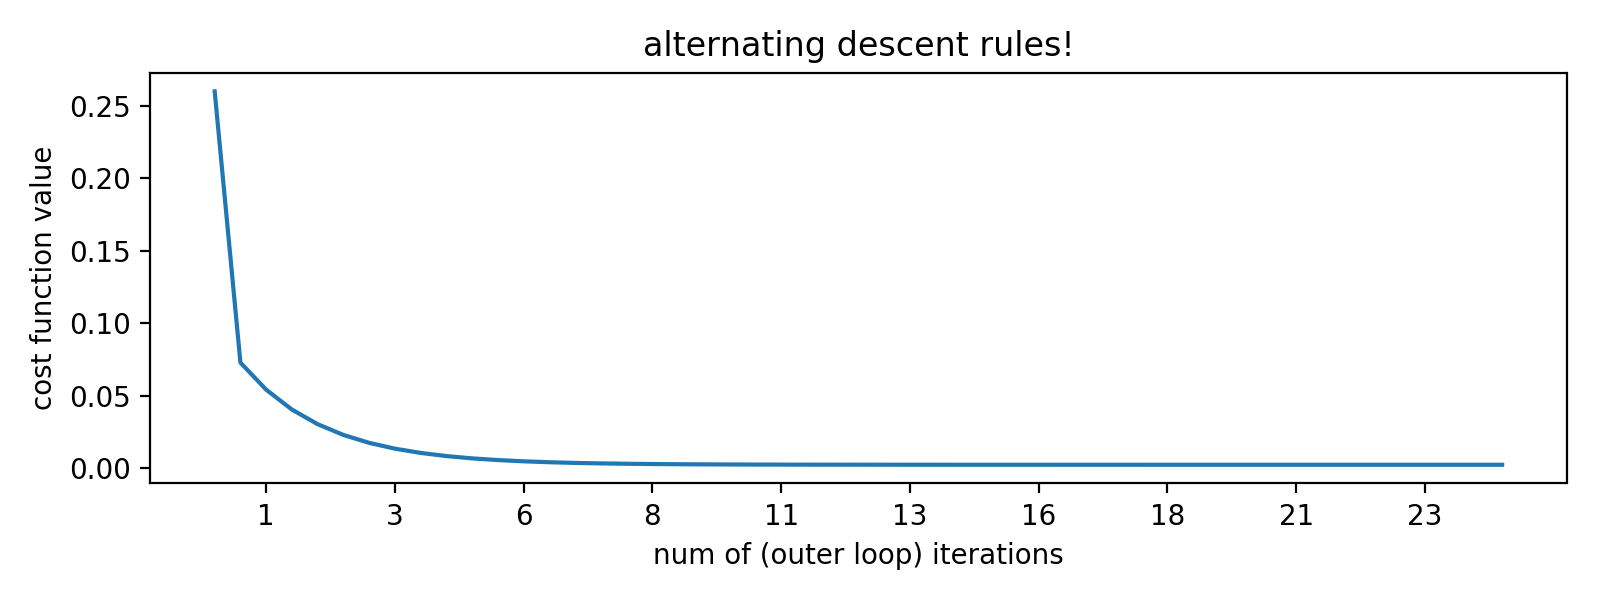

In [11]:
# define the components of quadratic
a,b,C = transform_least_squares_to_quadratic(x,y)

# define the quadratic
g = lambda w: (1/float(len(y)))*(a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

# run alternating descent for said number of iterations
w_history = alternating_descent_for_quadratic(a,b,C)

# plot resulting cost function history based on w_history
demo = custom_plotter.Visualizer();
demo.plot_alternating_descent_cost_history(g,w_history)

Finally - you can plot the dataset and fit provided by the final weight output from your run of alternating descent.

<IPython.core.display.Javascript object>


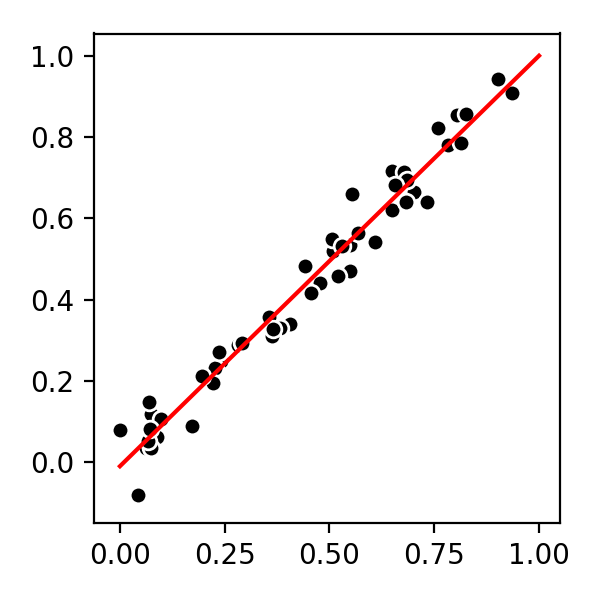

In [12]:
# our initial weights
w = w_history[-1]

# scatter plot the input data
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(data[:,0],data[:,1],color = 'k',edgecolor = 'w')

# fit a trend line
x_vals = np.linspace(0,1,200)
y_vals = w[0] + w[1]*x_vals
ax.plot(x_vals,y_vals,color = 'r')
plt.show()